# Subtask 1: Polarization Detection with XLM-RoBERTa-Large + LoRA

Binary classification for multilingual polarization detection using XLM-RoBERTa-Large with LoRA fine-tuning.

- **Model**: XLM-RoBERTa-Large (560M parameters)
- **Method**: LoRA (Low-Rank Adaptation) via PEFT library
- **Task**: Binary classification (Polarized vs Not Polarized)

## 1. Environment Setup

In [1]:
# Install required packages
!pip install -q transformers datasets peft accelerate bitsandbytes
!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm
!pip install -q wandb  # Optional: for experiment tracking

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 45.7 MB/s eta 0:00:00


In [2]:
import os
import gc
import json
import random
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed
)

from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel
)

warnings.filterwarnings('ignore')

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA L4
GPU Memory: 23.80 GB


In [3]:
class Config:
    # Model configuration
    MODEL_NAME = "xlm-roberta-large"

    # LoRA configuration
    LORA_R = 32
    LORA_ALPHA = 64
    LORA_DROPOUT = 0.05
    LORA_TARGET_MODULES = ["query", "key", "value", "dense"]

    # Training configuration
    MAX_LENGTH = 384
    BATCH_SIZE = 16
    EVAL_BATCH_SIZE = 32
    LEARNING_RATE = 1.5e-4
    NUM_EPOCHS = 5
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    GRADIENT_ACCUMULATION_STEPS = 2

    # Data configuration
    VALIDATION_SPLIT = 0.1
    USE_ALL_LANGUAGES = True
    SELECTED_LANGUAGES = ["eng", "hin", "arb", "spa", "deu"]

    # Class weighting
    USE_CLASS_WEIGHTS = True

    # Paths
    DATA_DIR = "subtask1"
    OUTPUT_DIR = "./output_subtask1_xlmr_lora"

    # Reproducibility
    SEED = 42

    # Device
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()
set_seed(config.SEED)
print(f"Using device: {config.DEVICE}")
print(f"Model: {config.MODEL_NAME}")

Using device: cuda
Model: xlm-roberta-large


## 2. Data Loading and Preprocessing

In [4]:

from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Unzipping {filename}...")
    !unzip -q "{filename}"


Saving dev_phase.zip to dev_phase.zip
Unzipping dev_phase.zip...


In [5]:
def load_all_training_data(data_dir: str, languages: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Load training data from all language files.
    """
    train_dir = Path(data_dir) / "train"
    all_files = list(train_dir.glob("*.csv"))

    print(f"Found {len(all_files)} language files in {train_dir}")

    dataframes = []
    stats = []

    for file_path in tqdm(all_files, desc="Loading data"):
        lang_code = file_path.stem

        if languages is not None and lang_code not in languages:
            continue

        try:
            df = pd.read_csv(file_path)

            if 'text' not in df.columns or 'polarization' not in df.columns:
                print(f"Warning: {file_path} missing required columns, skipping")
                continue

            df = df.dropna(subset=['text', 'polarization'])
            df['polarization'] = df['polarization'].astype(int)
            df['language'] = lang_code

            class_counts = df['polarization'].value_counts().to_dict()
            stats.append({
                'language': lang_code,
                'total': len(df),
                'class_0': class_counts.get(0, 0),
                'class_1': class_counts.get(1, 0),
                'polarization_ratio': class_counts.get(1, 0) / len(df) if len(df) > 0 else 0
            })

            dataframes.append(df)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    combined_df = pd.concat(dataframes, ignore_index=True)
    stats_df = pd.DataFrame(stats)

    print("\nDataset Statistics:")
    print(stats_df.to_string(index=False))
    print(f"\nTotal samples: {len(combined_df)}")
    print(f"Total languages: {combined_df['language'].nunique()}")
    print(f"Class distribution: {combined_df['polarization'].value_counts().to_dict()}")

    return combined_df, stats_df

def load_dev_data(data_dir: str) -> pd.DataFrame:
    """
    Load development/test data (without labels) for inference.
    """
    dev_dir = Path(data_dir) / "dev"
    all_files = list(dev_dir.glob("*.csv"))

    dataframes = []

    for file_path in tqdm(all_files, desc="Loading dev data"):
        lang_code = file_path.stem
        try:
            df = pd.read_csv(file_path)
            df['language'] = lang_code
            dataframes.append(df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Loaded {len(combined_df)} dev samples from {len(all_files)} languages")

    return combined_df

In [6]:
# 1. Set the correct base path (the one we fixed earlier)
config.DATA_DIR = '/content/dev_phase/subtask1'

# 2. Use 'load_all_training_data' to load the training files
if config.USE_ALL_LANGUAGES:
    train_df, stats_df = load_all_training_data(config.DATA_DIR)
else:
    train_df, stats_df = load_all_training_data(config.DATA_DIR, config.SELECTED_LANGUAGES)

# 3. Use 'load_dev_data' to load the dev files for the inference phase
dev_df = load_dev_data(config.DATA_DIR)

Found 22 language files in /content/dev_phase/subtask1/train


Loading data:   0%|          | 0/22 [00:00<?, ?it/s]


Dataset Statistics:
language  total  class_0  class_1  polarization_ratio
     deu   3180     1668     1512            0.475472
     tur   2364     1209     1155            0.488579
     ori   2368     1685      683            0.288429
     hin   2744      398     2346            0.854956
     ita   3334     1966     1368            0.410318
     spa   3305     1645     1660            0.502269
     pan   1700      860      840            0.494118
     tel   2366     1092     1274            0.538462
     hau   3651     3259      392            0.107368
     fas   3295      855     2440            0.740516
     khm   6640      611     6029            0.907982
     urd   3563     1087     2476            0.694920
     mya   2889     1207     1682            0.582208
     ben   3333     1909     1424            0.427243
     swa   6991     3487     3504            0.501216
     pol   2391     1388     1003            0.419490
     amh   3332      814     2518            0.755702
     en

Loading dev data:   0%|          | 0/22 [00:00<?, ?it/s]

Loaded 3687 dev samples from 22 languages


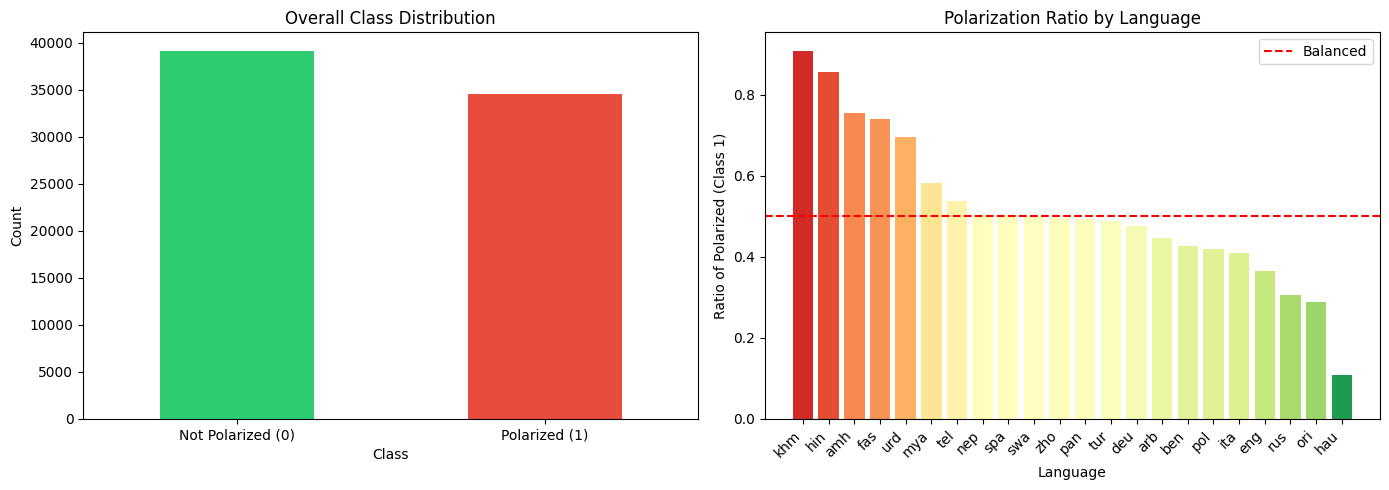

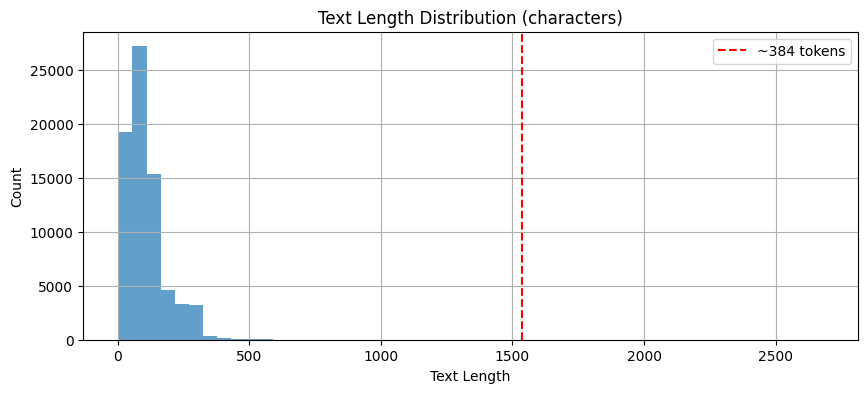


Text length statistics:
count    73681.000000
mean       106.762463
std         75.054154
min          2.000000
25%         54.000000
50%         89.000000
75%        131.000000
max       2680.000000
Name: text_length, dtype: float64


In [7]:
# Visualize class distribution per language
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
ax1 = axes[0]
train_df['polarization'].value_counts().plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Overall Class Distribution')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Not Polarized (0)', 'Polarized (1)'], rotation=0)

# Per-language distribution
ax2 = axes[1]
stats_df_sorted = stats_df.sort_values('polarization_ratio', ascending=False)
bars = ax2.bar(stats_df_sorted['language'], stats_df_sorted['polarization_ratio'],
               color=plt.cm.RdYlGn_r(stats_df_sorted['polarization_ratio']))
ax2.axhline(y=0.5, color='r', linestyle='--', label='Balanced')
ax2.set_title('Polarization Ratio by Language')
ax2.set_xlabel('Language')
ax2.set_ylabel('Ratio of Polarized (Class 1)')
ax2.set_xticklabels(stats_df_sorted['language'], rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.show()

# Text length distribution
train_df['text_length'] = train_df['text'].str.len()
fig, ax = plt.subplots(figsize=(10, 4))
train_df['text_length'].hist(bins=50, ax=ax, alpha=0.7)
ax.axvline(x=config.MAX_LENGTH * 4, color='r', linestyle='--', label=f'~{config.MAX_LENGTH} tokens')
ax.set_title('Text Length Distribution (characters)')
ax.set_xlabel('Text Length')
ax.set_ylabel('Count')
ax.legend()
plt.show()

print(f"\nText length statistics:")
print(train_df['text_length'].describe())

In [8]:
# Create train/validation split with stratification

# Create a combined stratification column
train_df['strat_col'] = train_df['language'] + '_' + train_df['polarization'].astype(str)

# Handle cases where some strata have too few samples
strat_counts = train_df['strat_col'].value_counts()
min_samples = 2  # Minimum samples per stratum for stratified split

# For strata with very few samples, we'll use only polarization for stratification
valid_strat = strat_counts[strat_counts >= min_samples].index
train_df['use_full_strat'] = train_df['strat_col'].isin(valid_strat)

# Split the data
train_data, val_data = train_test_split(
    train_df,
    test_size=config.VALIDATION_SPLIT,
    random_state=config.SEED,
    stratify=train_df['polarization']  # Stratify by label at minimum
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"\nTraining class distribution:")
print(train_data['polarization'].value_counts())
print(f"\nValidation class distribution:")
print(val_data['polarization'].value_counts())

Training samples: 66312
Validation samples: 7369

Training class distribution:
polarization
1    35230
0    31082
Name: count, dtype: int64

Validation class distribution:
polarization
1    3915
0    3454
Name: count, dtype: int64


## 3. Dataset Class and Tokenization

In [9]:
class PolarizationDataset(Dataset):
    """
    PyTorch Dataset for polarization classification.
    Handles tokenization and proper formatting for transformers.
    """

    def __init__(
        self,
        texts: List[str],
        labels: Optional[List[int]],
        tokenizer,
        max_length: int = 256
    ):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
            return_tensors=None  # Return lists
        )

        item = {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }

        if self.has_labels:
            item['labels'] = self.labels[idx]

        return item

In [10]:
# Load tokenizer
print(f"Loading tokenizer: {config.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

# Test tokenization on a sample
sample_texts = [
    "Fascist oligarchs now control the USA",  # English - Polarized
    "The EU is increasing military aid to Ukraine",  # English - Not polarized
    "#मोदी_हटाओ_देश_बचाओ",  # Hindi
    "والله يا احلام تبقين بعيني زباله",  # Arabic
]

print("\nTokenization examples:")
for text in sample_texts:
    tokens = tokenizer(text, truncation=True, max_length=50)
    decoded = tokenizer.decode(tokens['input_ids'])
    print(f"Text: {text[:50]}...")
    print(f"Tokens: {len(tokens['input_ids'])}")
    print(f"Decoded: {decoded[:50]}...")
    print()

Loading tokenizer: xlm-roberta-large


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]


Tokenization examples:
Text: Fascist oligarchs now control the USA...
Tokens: 13
Decoded: <s> Fascist oligarchs now control the USA</s>...

Text: The EU is increasing military aid to Ukraine...
Tokens: 10
Decoded: <s> The EU is increasing military aid to Ukraine</...

Text: #मोदी_हटाओ_देश_बचाओ...
Tokens: 15
Decoded: <s> #मोदी_हटाओ_देश_बचाओ</s>...

Text: والله يا احلام تبقين بعيني زباله...
Tokens: 11
Decoded: <s> والله يا احلام تبقين بعيني زباله</s>...



In [11]:
# Create datasets
train_dataset = PolarizationDataset(
    texts=train_data['text'].tolist(),
    labels=train_data['polarization'].tolist(),
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

val_dataset = PolarizationDataset(
    texts=val_data['text'].tolist(),
    labels=val_data['polarization'].tolist(),
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

# Dev dataset (no labels)
dev_dataset = PolarizationDataset(
    texts=dev_df['text'].tolist(),
    labels=None,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Dev dataset size: {len(dev_dataset)}")

Train dataset size: 66312
Validation dataset size: 7369
Dev dataset size: 3687


## 4. Model Setup with LoRA

In [12]:
# Compute class weights for handling imbalance
if config.USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=train_data['polarization'].values
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(config.DEVICE)
    print(f"Class weights: {class_weights}")
else:
    class_weights = None

Class weights: tensor([1.0667, 0.9411], device='cuda:0')


In [13]:
# Load base model
print(f"Loading model: {config.MODEL_NAME}")

# Load model with classification head
model = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=2,
    id2label={0: "Not Polarized", 1: "Polarized"},
    label2id={"Not Polarized": 0, "Polarized": 1}
)

print(f"\nBase model parameters: {model.num_parameters():,}")

Loading model: xlm-roberta-large


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Base model parameters: 559,892,482


In [14]:
# Configure LoRA
print("Configuring LoRA...")


lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=config.LORA_R,
    lora_alpha=config.LORA_ALPHA,
    lora_dropout=config.LORA_DROPOUT,
    target_modules=config.LORA_TARGET_MODULES,
    bias="none",  # Can be "none", "all", or "lora_only"
    modules_to_save=["classifier"]  # Train the classifier head fully
)

print(f"\nLoRA Configuration:")
print(f"  Rank (r): {config.LORA_R}")
print(f"  Alpha: {config.LORA_ALPHA}")
print(f"  Dropout: {config.LORA_DROPOUT}")
print(f"  Target modules: {config.LORA_TARGET_MODULES}")

Configuring LoRA...

LoRA Configuration:
  Rank (r): 32
  Alpha: 64
  Dropout: 0.05
  Target modules: ['query', 'key', 'value', 'dense']


In [15]:
# Apply LoRA to model
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

# Move to device
model = model.to(config.DEVICE)

trainable params: 15,207,426 || all params: 575,099,908 || trainable%: 2.6443


## 5. Training Setup

In [16]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for the Trainer.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate various metrics
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)

    # Per-class F1
    f1_per_class = f1_score(labels, predictions, average=None)

    return {
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision,
        'recall_macro': recall,
        'accuracy': accuracy,
        'f1_class_0': f1_per_class[0],
        'f1_class_1': f1_per_class[1]
    }

In [17]:
class WeightedTrainer(Trainer):
    """
    Custom Trainer that supports class weights for imbalanced datasets.
    """

    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [18]:
# Create output directory
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

# Training arguments
training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,

    # Training hyperparameters
    num_train_epochs=config.NUM_EPOCHS,
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.EVAL_BATCH_SIZE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,

    # Optimization
    warmup_ratio=config.WARMUP_RATIO,
    weight_decay=config.WEIGHT_DECAY,
    optim="adamw_torch",
    lr_scheduler_type="cosine",

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # Logging
    logging_dir=f"{config.OUTPUT_DIR}/logs",
    logging_steps=100,
    report_to="none",  # Set to "wandb" if using Weights & Biases

    # Efficiency
    fp16=torch.cuda.is_available(),  # Use mixed precision on GPU
    dataloader_num_workers=2,

    # Saving
    save_total_limit=2,

    # Reproducibility
    seed=config.SEED,
    data_seed=config.SEED,
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
    return_tensors="pt"
)

print("Training configuration:")
print(f"  Epochs: {config.NUM_EPOCHS}")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Effective batch size: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS}")
print(f"  Learning rate: {config.LEARNING_RATE}")
print(f"  Total training steps: {len(train_dataset) // (config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS) * config.NUM_EPOCHS}")

Training configuration:
  Epochs: 5
  Batch size: 16
  Effective batch size: 32
  Learning rate: 0.00015
  Total training steps: 10360


In [19]:
# Create trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

## 6. Training

In [20]:
# Clear GPU memory before training
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Starting training...")
train_result = trainer.train()
print("Training completed")

Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Accuracy,F1 Class 0,F1 Class 1
1,0.464200,0.418906,0.799665,0.800032,0.799965,0.801139,0.799837,0.793793,0.805537
2,0.418500,0.390229,0.818202,0.819004,0.818616,0.817893,0.819107,0.805373,0.831031
3,0.348200,0.404264,0.826925,0.827749,0.827759,0.826399,0.827928,0.813749,0.840101
4,0.260200,0.404813,0.826809,0.827147,0.826982,0.828267,0.826978,0.821404,0.832215
5,0.251100,0.442573,0.829020,0.829690,0.829026,0.829014,0.829692,0.818300,0.839739


Training completed


In [21]:
# Print training metrics
print("\nTraining Metrics:")
print(f"  Total training time: {train_result.metrics['train_runtime']:.2f}s")
print(f"  Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"  Final training loss: {train_result.metrics['train_loss']:.4f}")


Training Metrics:
  Total training time: 3755.14s
  Samples/second: 88.30
  Final training loss: 0.3739


In [22]:
# Evaluate on validation set
print("Evaluating on validation set...")
eval_results = trainer.evaluate()

print("\nValidation Results:")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Evaluating on validation set...



Validation Results:
  eval_loss: 0.4426
  eval_f1_macro: 0.8290
  eval_f1_weighted: 0.8297
  eval_precision_macro: 0.8290
  eval_recall_macro: 0.8290
  eval_accuracy: 0.8297
  eval_f1_class_0: 0.8183
  eval_f1_class_1: 0.8397
  eval_runtime: 23.9873
  eval_samples_per_second: 307.2040
  eval_steps_per_second: 9.6300
  epoch: 5.0000


Generating detailed predictions on validation set...



Classification Report:
                   precision    recall  f1-score   support

Not Polarized (0)       0.82      0.82      0.82      3454
    Polarized (1)       0.84      0.84      0.84      3915

         accuracy                           0.83      7369
        macro avg       0.83      0.83      0.83      7369
     weighted avg       0.83      0.83      0.83      7369



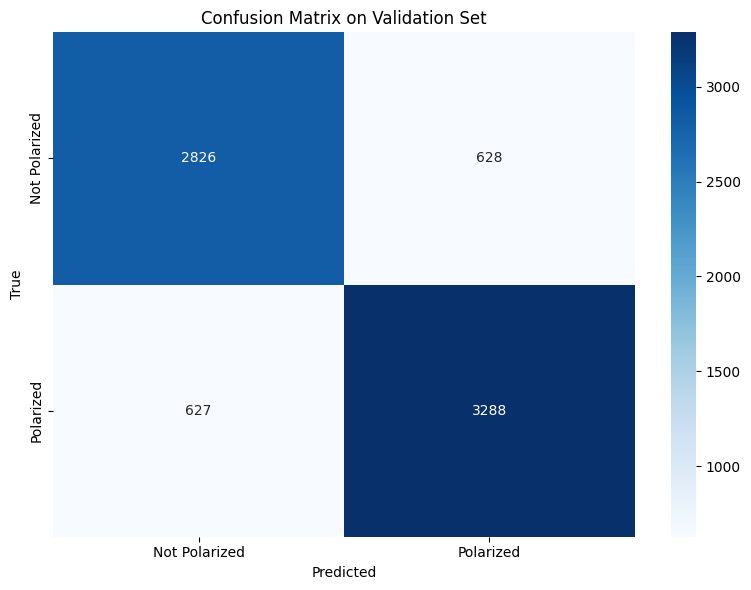

In [23]:
# Detailed evaluation with confusion matrix and classification report
print("Generating detailed predictions on validation set...")

predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = val_data['polarization'].values

print("\nClassification Report:")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=['Not Polarized (0)', 'Polarized (1)']
))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Not Polarized', 'Polarized'],
            yticklabels=['Not Polarized', 'Polarized'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix on Validation Set')
plt.tight_layout()
plt.show()

Per-Language Performance on Validation Set:
language  samples  f1_macro  accuracy
     nep      172  0.941663  0.941860
     mya      294  0.897155  0.897959
     zho      432  0.888696  0.888889
     tel      230  0.886922  0.886957
     ben      339  0.843856  0.846608
     tur      240  0.836863  0.837500
     hau      385  0.831203  0.935065
     arb      327  0.817827  0.819572
     pol      281  0.788162  0.793594
     rus      351  0.787227  0.806268
     hin      315  0.780220  0.898413
     eng      341  0.778808  0.800587
     fas      334  0.777375  0.841317
     ori      187  0.769349  0.828877
     amh      315  0.765947  0.834921
     swa      681  0.758948  0.759178
     urd      369  0.751515  0.804878
     khm      651  0.748476  0.944700
     deu      304  0.733894  0.736842
     spa      329  0.729473  0.729483
     pan      160  0.704855  0.706250
     ita      332  0.631691  0.653614


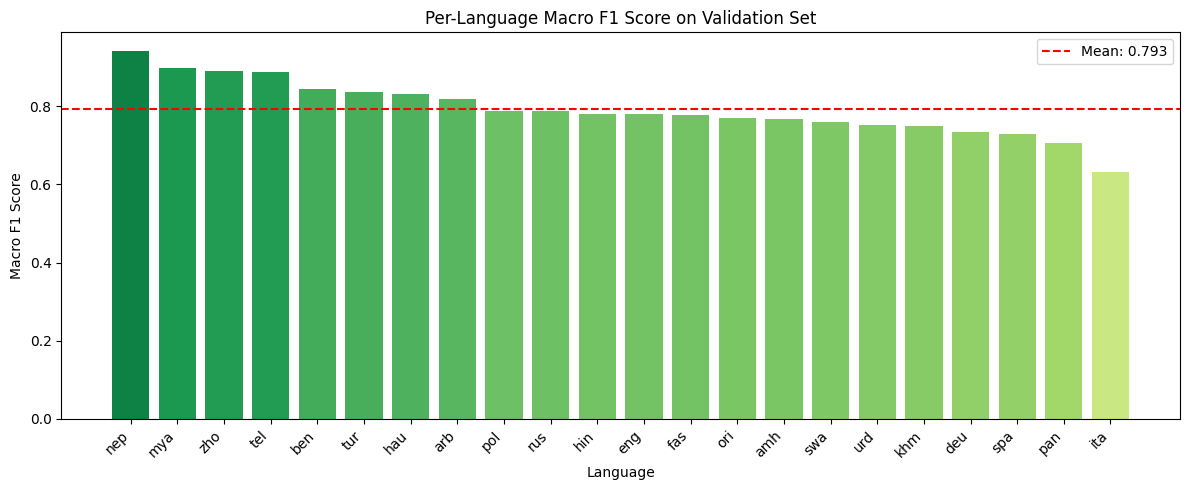

In [24]:
# Per-language evaluation
print("Per-Language Performance on Validation Set:")

val_data_with_preds = val_data.copy()
val_data_with_preds['predicted'] = pred_labels

per_lang_results = []
for lang in val_data_with_preds['language'].unique():
    lang_data = val_data_with_preds[val_data_with_preds['language'] == lang]
    if len(lang_data) > 0:
        f1 = f1_score(lang_data['polarization'], lang_data['predicted'], average='macro')
        acc = accuracy_score(lang_data['polarization'], lang_data['predicted'])
        per_lang_results.append({
            'language': lang,
            'samples': len(lang_data),
            'f1_macro': f1,
            'accuracy': acc
        })

per_lang_df = pd.DataFrame(per_lang_results).sort_values('f1_macro', ascending=False)
print(per_lang_df.to_string(index=False))

# Visualize per-language performance
fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(per_lang_df['language'], per_lang_df['f1_macro'],
              color=plt.cm.RdYlGn(per_lang_df['f1_macro']))
ax.axhline(y=per_lang_df['f1_macro'].mean(), color='r', linestyle='--',
           label=f'Mean: {per_lang_df["f1_macro"].mean():.3f}')
ax.set_xlabel('Language')
ax.set_ylabel('Macro F1 Score')
ax.set_title('Per-Language Macro F1 Score on Validation Set')
ax.set_xticklabels(per_lang_df['language'], rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

## 7. Save Model

In [25]:
# Save the LoRA adapter weights
model.save_pretrained(f"{config.OUTPUT_DIR}/lora_adapter")
tokenizer.save_pretrained(f"{config.OUTPUT_DIR}/lora_adapter")

print(f"\nModel saved to {config.OUTPUT_DIR}/lora_adapter")
print(f"\nFiles saved:")
for f in os.listdir(f"{config.OUTPUT_DIR}/lora_adapter"):
    print(f"  - {f}")


Model saved to ./output_subtask1_xlmr_lora/lora_adapter

Files saved:
  - README.md
  - adapter_model.safetensors
  - tokenizer_config.json
  - special_tokens_map.json
  - sentencepiece.bpe.model
  - adapter_config.json
  - tokenizer.json


In [26]:
# Save training configuration
config_dict = {
    'model_name': config.MODEL_NAME,
    'lora_r': config.LORA_R,
    'lora_alpha': config.LORA_ALPHA,
    'lora_dropout': config.LORA_DROPOUT,
    'lora_target_modules': config.LORA_TARGET_MODULES,
    'max_length': config.MAX_LENGTH,
    'batch_size': config.BATCH_SIZE,
    'learning_rate': config.LEARNING_RATE,
    'num_epochs': config.NUM_EPOCHS,
    'validation_f1_macro': eval_results['eval_f1_macro'],
    'validation_accuracy': eval_results['eval_accuracy']
}

with open(f"{config.OUTPUT_DIR}/training_config.json", 'w') as f:
    json.dump(config_dict, f, indent=2)

print("Training configuration saved.")

Training configuration saved.


## 8. Inference on Dev Set

In [27]:
def predict_batch(model, tokenizer, texts, batch_size=32, max_length=256, device='cuda'):
    """
    Generate predictions for a batch of texts.
    """
    model.eval()
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
            batch_texts = texts[i:i+batch_size]

            # Tokenize
            encodings = tokenizer(
                batch_texts,
                truncation=True,
                max_length=max_length,
                padding=True,
                return_tensors='pt'
            )

            # Move to device
            encodings = {k: v.to(device) for k, v in encodings.items()}

            # Get predictions
            outputs = model(**encodings)
            logits = outputs.logits

            # Convert to probabilities and predictions
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_predictions.extend(preds.cpu().numpy())
            all_probabilities.extend(probs.cpu().numpy())

    return np.array(all_predictions), np.array(all_probabilities)

In [28]:
# Generate predictions on dev set
print("Generating predictions on dev set...")

dev_texts = dev_df['text'].tolist()
dev_predictions, dev_probabilities = predict_batch(
    model=model,
    tokenizer=tokenizer,
    texts=dev_texts,
    batch_size=config.EVAL_BATCH_SIZE,
    max_length=config.MAX_LENGTH,
    device=config.DEVICE
)

# Add predictions to dev dataframe
dev_df['polarization_pred'] = dev_predictions
dev_df['prob_not_polarized'] = dev_probabilities[:, 0]
dev_df['prob_polarized'] = dev_probabilities[:, 1]

print(f"\nDev Set Prediction Distribution:")
print(dev_df['polarization_pred'].value_counts())

Generating predictions on dev set...


Predicting:   0%|          | 0/116 [00:00<?, ?it/s]


Dev Set Prediction Distribution:
polarization_pred
1    1947
0    1740
Name: count, dtype: int64


In [29]:
# Generate submission files for Codabench
import os
import zipfile
from pathlib import Path

SUBMISSION_DIR = "./submission"
SUBTASK_DIR = f"{SUBMISSION_DIR}/subtask_1"

os.makedirs(SUBTASK_DIR, exist_ok=True)

print("Generating submission files...")

languages_processed = []

for lang in sorted(dev_df['language'].unique()):
    lang_df = dev_df[dev_df['language'] == lang].copy()
    submission_df = lang_df[['id', 'polarization_pred']].copy()
    submission_df.columns = ['id', 'polarization']

    output_file = f"{SUBTASK_DIR}/pred_{lang}.csv"
    submission_df.to_csv(output_file, index=False)

    languages_processed.append(lang)
    print(f"  {lang}: {len(submission_df)} predictions")

print(f"\nTotal: {len(languages_processed)} languages, {len(dev_df)} predictions")

# Verify format
sample_file = f"{SUBTASK_DIR}/pred_{languages_processed[0]}.csv"
sample_df = pd.read_csv(sample_file)
print(f"\nFormat verification (first file):")
print(sample_df.head(3).to_string(index=False))

# Create ZIP file
zip_filename = f"{SUBMISSION_DIR}/subtask_1_submission.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for lang in languages_processed:
        file_path = f"{SUBTASK_DIR}/pred_{lang}.csv"
        zipf.write(file_path, f"subtask_1/pred_{lang}.csv")

print(f"\nZIP created: {zip_filename}")

# Prediction distribution
total_not_pol = (dev_df['polarization_pred'] == 0).sum()
total_pol = (dev_df['polarization_pred'] == 1).sum()
print(f"\nPrediction distribution:")
print(f"  Not Polarized (0): {total_not_pol} ({total_not_pol / len(dev_df) * 100:.1f}%)")
print(f"  Polarized (1): {total_pol} ({total_pol / len(dev_df) * 100:.1f}%)")

# Save metadata
metadata = {
    'submission_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model': config.MODEL_NAME,
    'total_predictions': len(dev_df),
    'languages': sorted(languages_processed),
    'validation_f1_macro': eval_results['eval_f1_macro'],
    'prediction_distribution': {
        'not_polarized': int(total_not_pol),
        'polarized': int(total_pol)
    }
}

import json
with open(f"{SUBMISSION_DIR}/submission_metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved: {SUBMISSION_DIR}/submission_metadata.json")

Generating submission files...
  amh: 166 predictions
  arb: 169 predictions
  ben: 166 predictions
  deu: 159 predictions
  eng: 160 predictions
  fas: 164 predictions
  hau: 182 predictions
  hin: 137 predictions
  ita: 166 predictions
  khm: 332 predictions
  mya: 144 predictions
  nep: 100 predictions
  ori: 118 predictions
  pan: 100 predictions
  pol: 119 predictions
  rus: 167 predictions
  spa: 165 predictions
  swa: 349 predictions
  tel: 118 predictions
  tur: 115 predictions
  urd: 177 predictions
  zho: 214 predictions

Total: 22 languages, 3687 predictions

Format verification (first file):
                                  id  polarization
amh_ca702c5ddc6b46c73576c8f6d3f0c0b6             0
amh_1fcbc6173a80cddfce64017e171419fd             0
amh_d9be456f48f7c180812de29d43935f96             1

ZIP created: ./submission/subtask_1_submission.zip

Prediction distribution:
  Not Polarized (0): 1740 (47.2%)
  Polarized (1): 1947 (52.8%)
Metadata saved: ./submission/submission_met

In [30]:
# Save predictions in the required format

submission_df = dev_df[['id', 'text', 'polarization_pred']].copy()
submission_df.columns = ['id', 'text', 'polarization']

# Save as single file
submission_df.to_csv(f"{config.OUTPUT_DIR}/dev_predictions.csv", index=False)
print(f"\nPredictions saved to {config.OUTPUT_DIR}/dev_predictions.csv")

# Also save per-language files (as the dev set might be organized this way)
os.makedirs(f"{config.OUTPUT_DIR}/dev_predictions_by_language", exist_ok=True)

for lang in dev_df['language'].unique():
    lang_df = dev_df[dev_df['language'] == lang][['id', 'text', 'polarization_pred']].copy()
    lang_df.columns = ['id', 'text', 'polarization']
    lang_df.to_csv(f"{config.OUTPUT_DIR}/dev_predictions_by_language/{lang}.csv", index=False)

print(f"Per-language predictions saved to {config.OUTPUT_DIR}/dev_predictions_by_language/")


Predictions saved to ./output_subtask1_xlmr_lora/dev_predictions.csv
Per-language predictions saved to ./output_subtask1_xlmr_lora/dev_predictions_by_language/


In [31]:
# Show some prediction examples
print("Sample Predictions:\n")

for lang in ['eng', 'hin', 'arb']:
    if lang in dev_df['language'].values:
        print(f"{lang.upper()}:")
        lang_samples = dev_df[dev_df['language'] == lang].head(3)
        for _, row in lang_samples.iterrows():
            print(f"  Text: {row['text'][:80]}...")
            print(f"  Prediction: {'Polarized' if row['polarization_pred'] == 1 else 'Not Polarized'}")
            print(f"  Confidence: {max(row['prob_polarized'], row['prob_not_polarized']):.3f}")
            print()

Sample Predictions:

ENG:
  Text: God is with Ukraine and Zelensky...
  Prediction: Not Polarized
  Confidence: 0.978

  Text: 4 Dems, 2 Republicans Luzerne County Council seatsDallas...
  Prediction: Not Polarized
  Confidence: 0.999

  Text: Abuse Survivor Recounts Her Struggles at YWCA Event...
  Prediction: Not Polarized
  Confidence: 0.999

HIN:
  Text: और इस तरह बीजेपी ने अपना इस्लामीकरण कर लिया...
  Prediction: Polarized
  Confidence: 0.996

  Text: ओरीजनल हिंदुत्व यही है ।...
  Prediction: Polarized
  Confidence: 0.544

  Text: हिंदुत्व की चर्बी उतर गई...
  Prediction: Polarized
  Confidence: 0.957

ARB:
  Text: حيل بيج يانذله تحجين ع العراقيات بس احنه العراقيات انشرفج وانشرف عشره مثلج...
  Prediction: Polarized
  Confidence: 0.895

  Text: على زبي
يا ليتها تجي معي البر اخليها تسوق دباب ما عليكم شباب لا تخافون علي بالبس...
  Prediction: Polarized
  Confidence: 0.586

  Text: كل المغنين ولي يدخلون  المسيقه  في  أغانيهم  نكرا ونتي أول وحده يا أحلام  😎...
  Prediction: Not Polariz